## Modelado de opiniones y su impacto en la generación de consensos y disensos en una plataforma de CrowdSourcing

El objetivo de la simulación es dilucidar el funcionamiento de las dinámicas de opinión en una plataforma de CrowdSourcing donde las personas expresan sus opiniones y votan las expresadas por otros bajo una serie de condiciones especificadas por el contexto de la plataforma.

In [12]:
import random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pandas import Series, DataFrame
from uuid import uuid4
#pd.options.mode.chained_assignment = None 

TamañoDeLaMuestra = [100, 200, 500, 1000] # Cantidad de agentes que quiero en la muestra.

# Agentes

## Agente

Agente es una clase que cuenta con los siguientes atributos:

* **Oi** = Contiene la opinion de cada agente. Va a ser siempre numerico pero dependiendo la simulacion puede ser un solo numero (real) o un vector de varios numeros (reales), independientemente de como se generan que siempre lo hacen a partir de la realizacion de algun tipo de distribucion conocida en un espacio univariado o multivariado.  
* **ID** = Es un numero entero definido bla bla
* **IdeasVistas** = Es una lista que contiene los IDs de las ideas que va a ver este agente.  
* **IdeasVotadas** = Es una lista que contiene los IDs de las ideas que va a ver este agente.
* **Valencias** = Es una lista que contiene el valor que toma el voto de este agente.

In [2]:
class Agente (object):
    def __init__ (self, tipo, ID):
        self.Oi = self.set_Oi (tipo)
        self.ID = ID
        self.IdeasVistas = []
        self.IdeasVotadas = []
        self.Valencias = []

###############################################################################################
# Tengo que configurar como generarle la opinion al sujeto

    def set_Oi (self, tipo):
        if tipo != "uniforme" and tipo != "normal":
            raise Exception("El tipo de opinion solo puede ser ""uniforme""o ""normal")
            
        if tipo == "uniforme":
            opinion = random.uniform (-1,1)
        # if tipo == "normal": 
            # opinion = ¤SETEAR LA OPINION NORMAL ###############################################################################################
        return opinion

###############################################################################################

    def append_IdeasVistas (self, IdeaVista):
        self.IdeasVistas.append (IdeaVista)

    def append_IdeasVotadas (self, IdeaVotada):
        self.IdeasVotadas.append (IdeaVotada)   

    def append_Valencias (self, Valencias):
        self.Valencias.append (Valencias) 

    def algvotar (self, ideas, tipo): # Asume que se le da un dataframe con las opiniones (distribuidas uniformemente),
        Comp = 3             # y devuelve cual es el ID de la idea mas cercana a la del sujeto
        vota = 0
        for i in ideas.index:
            V = abs(ideas.at[i,'Opinion']-self.Oi)
            if V == Comp:
                vota = random.randint (i, vota)
            elif tipo == "Positivo":
                if V < Comp:
                    vota = i
                    Comp = V
            elif tipo == "Negativo":
                if V > Comp:
                    vota = i
                    Comp = V                
        return vota # Me devuelve la id de la idea a votar 

    def ListaVotos (self, VotosPos, VotosNeg):
        votos = VotosPos * [1] + VotosNeg * [-1]
        return votos

    def comparar (self, idea): # Devuelve la distancia entre la opinion que se le pase y la del sujeto
        Distancia = abs(idea-self.Oi)
        return Distancia
    
    def get_Oi (self):
        return self.Oi
    
    def get_IdeasVistas (self):
        return self.IdeasVistas

    def get_ID (self):
        return self.ID
    
    def clean_IdeasVistas (self):
        self.IdeasVistas = []

### Agente Nulo

In [18]:
class AgenteNulo (Agente):  
    
    def votar (self, ideas): # Modelo de votacion aleatoria nulo
        self.IdeasVistas.append (ideas)
        Votara = ideas.sample (n = QIdeasAVotar)
        votos = self.ListaVotos(VotosPos, VotosNeg)
        vota = []
        for i in Votara.index:
            vota.append (i)
        self.IdeasVotadas.append (vota)
        self.Valencias.append (votos)
        devuelve = pd.DataFrame(votos, vota)
        return devuelve

## Agente Determinista

In [19]:
class AgenteDeterminista (AgenteNulo):
        
        def votar (self, ideas): # Aca solo elimino el tipo de votacion que va a quedar definido por la herencia de clase
            self.IdeasVistas.append (ideas)
            ideas2 = ideas.copy ()
            vota = []
            votos = self.ListaVotos(VotosPos, VotosNeg) # Esta funcion deberia tomar las variables globales que le paso a cada simulacion sobre cuantos votos quiero que tenga c/u nose si va a funcionar
            for i in votos:
                if i == 1:
                    va = self.algvotar (ideas2, "Positivo")
                    ideas2.drop (va)
                    vota.append (va)
                if i == -1:
                    va = self.algvotar (ideas2, "Negativo")
                    ideas2.drop (va)
                    vota.append (va)
            self.IdeasVotadas.append (vota)
            self.Valencias.append (votos)
            devuelve = pd.DataFrame(votos, vota)
            return devuelve

## Agente Probabilistico

In [20]:
class AgenteProbabilistico (AgenteNulo):
    pass
    # FALTA ARMAR ESTO ################################################################################


### Metodos se seleccion de ideas

Esta funcion define la manera en que se va a controlar las ideas que le van a ser presentadas a un agente. Existen dos metodos con que se pueden seleccionar las ideas dependiendo del argumento `tipo` pasado a la funcion.

* Metodo uno (`tipo = 'menos vistas'`): Comprende elegir aquellas ideas que tengan menor cantidad de vistas
* Metodo dos (`tipo = 'ratio'`): Comprende elegir en partes iguales, la mitad de las ideas segun la cantidad de vistas igual que con el metodo uno y la otra mitad de las ideas segun el ratio de votos positivos y cantidad de vistas. 

In [6]:
def metodo_de_seleccion (lista, tipo):
    
    if tipo == "menos vistas":
        lista.sort_values(by='Vistas', inplace=True)
        Devuelve = lista.iloc[:QOpinionesExpuestas, :2]
        return Devuelve
    
    if tipo == "ratio":
        lista.sort_values(by=['Votos'], ascending=False, inplace=True)
        OpinionesMasVotadas = lista.iloc[:10, :2] # 
        OpinionesMasVotadasSeleccionadas = OpinionesMasVotadas.sample (n=3)
        RestoDeOpiniones = lista.iloc[10:, :]
        RestoDeOpiniones.sort_values(by='Ratio', ascending=False, inplace=True)
        OpinionesConMayorRatio = RestoDeOpiniones.iloc[:10, :2]  # Creo un df con las 10 opiniones con mayor ratio
        OpinionesConMayorRatioSeleccionadas = OpinionesConMayorRatio.sample (n=5)  # Selecciono 5 de las 10 opiniones con mayor ratio
        OpinionesParaVotar = pd.concat([OpinionesMasVotadasSeleccionadas, OpinionesConMayorRatioSeleccionadas])
        return OpinionesParaVotar
    
        

### Simulacion Nula

Se crea un diccionario para albergar a todos los agentes que van a componer la muestra. Para crear el diccionario se itera sobre el rango del tamaño de la muestra a usar (estando los distintos tamaños definidos en una lista) y se genera un nuevo elemento del diccionario (una instancia de la clase correspondiente a algun tipo de agente) con un indice igual al ID del sujeto. 

In [14]:
Muestra_Completa = {}
for k in range (1,TamañoDeLaMuestra[1]):
    Muestra_Completa [k*111] = AgenteNulo ("uniforme",str(uuid4()))

#### Variables de entorno

Para el contexto de la simulacion es necesario definir algunas variables que van a determinar el contexto de la plataforma en la cual los agentes van a interactuar. Estas variables son:

* `QOpinionesExpuestas` = La cantidad de opiniones que va a ver cada agente. 
* `QVecesMuestroOpinion` = La cantidad minima de veces que quiero que se muestre alguna opinion, toda opinion de esta manera tiene que mostrarse al menos esta cantidad de veces. 
* `VotosPos` = Cuantos votos positivos tiene disponible cada agente.
* `VotosNeg` = Cuantos votos negativos tiene disponible cada agente.
* `QIdeasAVotar` = La cantidad total de ideas que un agente va a votar lo cual esta dado por la suma de la cantidad de votos negativos y positivos disponible para cada agente. 

In [15]:
QOpinionesExpuestas = 5 
QVecesMuestroOpinion = 15
VotosPos = 2
VotosNeg = 0
QIdeasAVotar = VotosPos + VotosNeg

-------------------------------------------------------------------------------------
Opiniones XXXX, con una distribucion XXXX [-1,1]
Algoritmo XXXX, del conjunto de XXXX


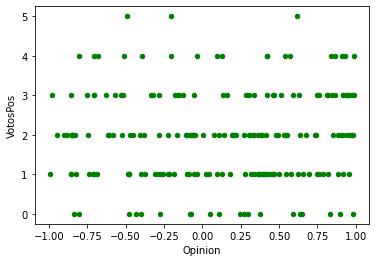

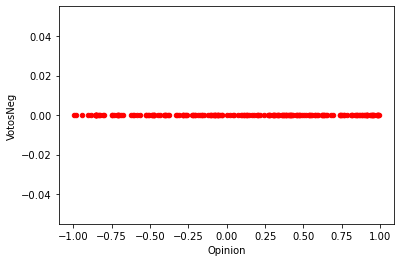

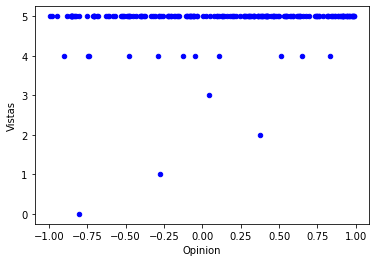

                                         ID   Opinion VotosPos VotosNeg  \
0      ece31743-4916-4dac-ae19-4d14f9b3f489     0.218        2        0   
1      fa21625e-478b-473a-8e87-c739be0d4c92 -0.284131        2        0   
2      ff400e95-18e6-4af5-9265-46e0fd58f35b -0.207648        5        0   
3      7608af5f-dcb2-4f1c-a58e-b83e38b9feff -0.737784        1        0   
4      21c365f1-4809-4108-94dc-73825a76d85c -0.259844        1        0   
...                                     ...       ...      ...      ...   
21645  15d73be8-76dd-4865-8d8b-40f5d8605e23 -0.125398        3        0   
21756  0c158fc4-e451-4d16-83c9-b25127635db6   0.04165        1        0   
21867  b551e978-b32f-4d58-800a-c16fec70f461   0.37363        0        0   
21978  6bca27ea-1fa5-40c8-b546-f719d482c200 -0.274674        0        0   
22089  2696463d-db8e-49d4-a897-8841405ab411 -0.801373        0        0   

      Vistas     Ratio  
0          5       0.4  
1          5       0.4  
2          5       1.0  

In [17]:
#¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤ Simulacion ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤#

Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
DataSave = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinuto = pd.DataFrame(columns=['Sujeto', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas: # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        DataSave.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = DataSave[DataSave.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas, "menos vistas") # Creo un dataframe con las ideas que va a ver el sujeto
        DataSave.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar)
        
        for i in VotoActual.index:
            
            if VotoActual.loc[i].at[0] == 1:
                DataSave.at [i,'VotosPos'] = DataSave.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.loc[i].at[0] == -1:
                DataSave.at [i,'VotosNeg'] = DataSave.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            DataSave.at [i,'Vistas'] = DataSave.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas
            
            ################################################################ DEBERIA CONFIGURAR ALGO PARA VER COMO AFECTAN LOS VOTOS NEGATIVOS EN EL RATIO?
            DataSave.at [i, 'Ratio'] = DataSave.at[i, 'VotosPos'] / DataSave.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinuto.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion']) 
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinuto.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

##### Visualizo la data
print ("-------------------------------------------------------------------------------------")
#print ("Muestra N: " + str(q))
print ("Opiniones XXXX, con una distribucion XXXX [-1,1]")
print ("Algoritmo XXXX, del conjunto de XXXX")
#print (DataSave.sort_values(by=['Votos'], ascending=False))
DataSave.plot(kind='scatter',x='Opinion',y='VotosPos',color='green')
DataSave.plot(kind='scatter',x='Opinion',y='VotosNeg',color='red')
DataSave.plot(kind='scatter',x='Opinion',y='Vistas',color='blue')
#plt.yticks(range(5))
plt.show()
